In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

In [2]:
base_dir = '/Users/das/work/svn/Gits/a_Projects/101_clembench/clembench-runs'

modprop_df = pd.read_csv(base_dir + '/Addenda/ModelAnalysis2024/Results/model_characteristics.csv')
modprop_df['Release Date'] = pd.to_datetime(modprop_df['Release Date'])
modprop_df['Cut-off Date'] = pd.to_datetime(modprop_df['Cut-off Date'])

## well fuck me. Turns out that the model names can contain trailing whitespaces...
modprop_df['Model Name'] = modprop_df['Model Name'].str.strip()


v16 = pd.read_csv(base_dir + '/v1.6/results.csv')
#v16.loc[:,'model'] = v16.iloc[:,0].str.replace(r'(\w*)-(?:hf-)?t0.0.*', r'\1').str.lower()
v16.loc[:,'model'] = v16.iloc[:,0].str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()


## f me part II: turns out that the results.csv has openchat_3.5, and modprop has openchat-3.5
##  normalise to the latter
v16.loc[v16.model == 'openchat_3.5', 'model'] = 'openchat-3.5'

merged = pd.merge(left=modprop_df, right=v16, left_on='Model Name', right_on='model')

(
 merged.model,
 set(v16.model) - set(merged.model)
)

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_62270/515090632.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  v16.loc[:,'model'] = v16.iloc[:,0].str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()


(0                        yi-34b-chat
 1                     yi-1.5-6b-chat
 2                     yi-1.5-9b-chat
 3                    yi-1.5-34b-chat
 4                     tulu-2-dpo-70b
 5                         claude-2.1
 6            claude-3-haiku-20240307
 7           claude-3-sonnet-20240229
 8             claude-3-opus-20240229
 9           dolphin-2.5-mixtral-8x7b
 10                         command-r
 11                    command-r-plus
 12                   gemma-1.1-7b-it
 13                       gemma-7b-it
 14           gemini-1.5-flash-latest
 15             gemini-1.5-pro-latest
 16                    gemini-1.0-pro
 17                   codegemma-7b-it
 18                   gemma-1.1-2b-it
 19       meta-llama-3-8b-instruct-hf
 20      meta-llama-3-70b-instruct-hf
 21               llama-2-70b-chat-hf
 22         codellama-34b-instruct-hf
 23          mistral-7b-instruct-v0.1
 24        mixtral-8x7b-instruct-v0.1
 25       mixtral-8x22b-instruct-v0.1
 26         

In [3]:
merged.columns

Index(['Model Provider', 'Model Name', 'Training Data Size (in trillions)',
       'Cut-off Date', 'Parameter Size (in billions)', 'Release Date',
       'Context Length (in thousands)', 'Commercial', 'Multilingual',
       'Multimodal', 'Base Model ', 'Instruction Tuning Data', 'Unnamed: 0',
       '-, clemscore', 'all, Average % Played', 'all, Average Quality Score',
       'imagegame, % Played', 'imagegame, Quality Score',
       'imagegame, Quality Score (std)', 'privateshared, % Played',
       'privateshared, Quality Score', 'privateshared, Quality Score (std)',
       'referencegame, % Played', 'referencegame, Quality Score',
       'referencegame, Quality Score (std)', 'taboo, % Played',
       'taboo, Quality Score', 'taboo, Quality Score (std)',
       'wordle, % Played', 'wordle, Quality Score',
       'wordle, Quality Score (std)', 'wordle_withclue, % Played',
       'wordle_withclue, Quality Score',
       'wordle_withclue, Quality Score (std)', 'wordle_withcritic, % Playe

### combined barplots

In [4]:
# based on https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html , 
#  with a lot less penguin
def barplot_maker(fig, ax, groups, features,
                  ylabel='', title='', width=0.25, ylim=(0,100),
                  rotation=45,
                  show_labels=True, show_ylabel=True, show_title=True, show_legend=True):
    x = np.arange(len(groups))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    for attribute, value in features.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, value, width, label=attribute)
        if show_labels:
            ax.bar_label(rects, padding=3)
        multiplier += 1
        #break

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if show_ylabel:
        ax.set_ylabel(ylabel)
    if show_title:
        ax.set_title(title)
    ax.set_xticks(x + width, groups, rotation=rotation, rotation_mode='anchor', horizontalalignment='right')
    if show_legend:
        ax.legend(loc='upper left', ncol=3)
    ax.set_ylim(ylim)

### across models, show a few features

In [5]:
def df_to_dict(df, attributes):
    out_dict = {}
    for attribute in attributes:
        out_dict[attribute] = df.loc[:, attribute].values
    return out_dict

In [6]:
df = merged[merged.model.str.contains('gpt')]
attributes = ['all, Average % Played', 'all, Average Quality Score']

out_dict = df_to_dict(df, attributes)
models = df.model

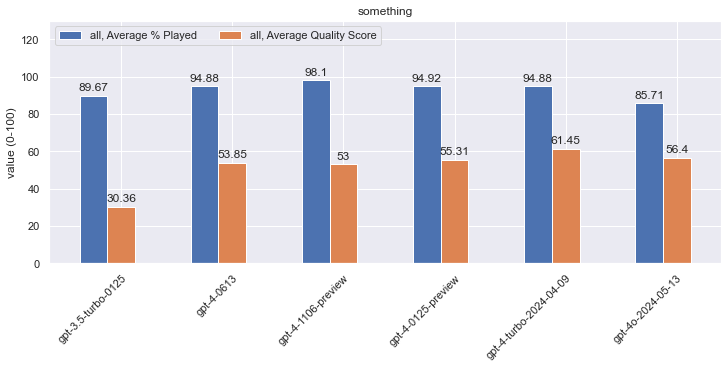

In [7]:
ylabel = 'value (0-100)'
title= 'something'

fig, ax = plt.subplots(layout='constrained')
barplot_maker(fig, ax, models, out_dict, ylabel, title, ylim=(0,130))
fig.set_size_inches(10, 5)

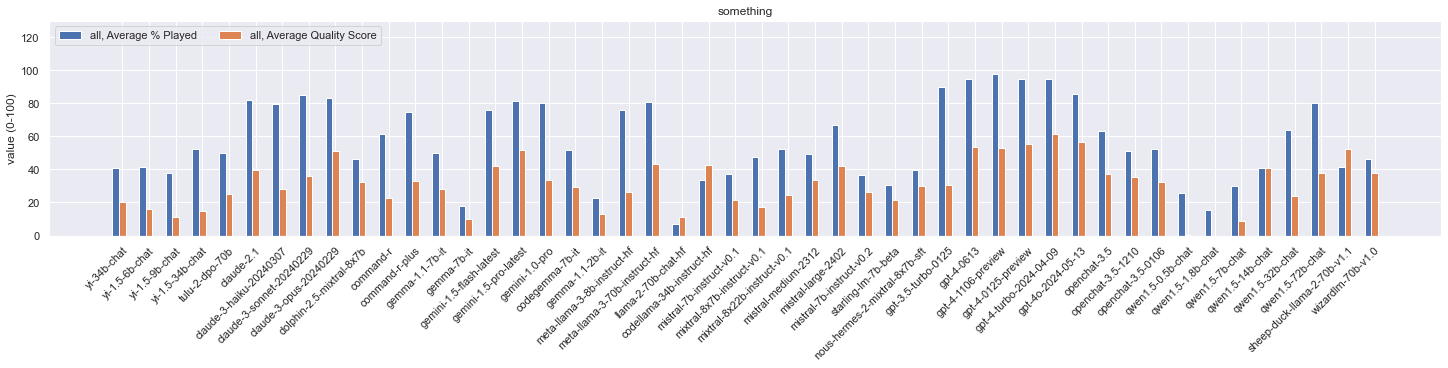

In [8]:
attributes = ['all, Average % Played', 'all, Average Quality Score']

out_dict = df_to_dict(merged, attributes)
models = merged.model


ylabel = 'value (0-100)'
title= 'something'

fig, ax = plt.subplots(layout='constrained')
barplot_maker(fig, ax, models, out_dict, ylabel=ylabel, title=title, ylim=(0,130), show_labels=False)

fig.set_size_inches(20, 5)

### Within model, show feature pairs

Different view: A single model. Each group is a game.. So the two features are '%-played' and 'quality', for each game...

In [9]:
this_model = merged.model[16]
this_model

'gemini-1.0-pro'

In [10]:
groups = [
    'imagegame',
    'privateshared',
    'referencegame',
    'taboo',
    'wordle',
    'wordle_withclue',
    'wordle_withcritic'    
]

attributes = ['% Played', 'Quality Score']

row = merged[merged.model == this_model]

out_dict = {}
for attribute in attributes:
    this_vals = []
    for group in groups:
        colname = group + ', ' + attribute
        this_vals.append(row[colname].values[0])
    out_dict[attribute] = this_vals

In [11]:
out_dict

{'% Played': [30.0, 76.0, 100.0, 85.0, 90.0, 86.67, 93.33],
 'Quality Score': [49.08, 63.7, 46.11, 55.23, 0.74, 12.82, 7.74]}

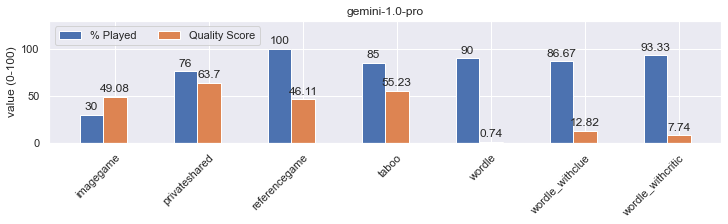

In [12]:
ylabel = 'value (0-100)'
title = this_model

fig, ax = plt.subplots(layout='constrained')
barplot_maker(fig, ax, groups, out_dict, ylabel=ylabel, title=title, ylim=(0,130))
fig.set_size_inches(10, 3)

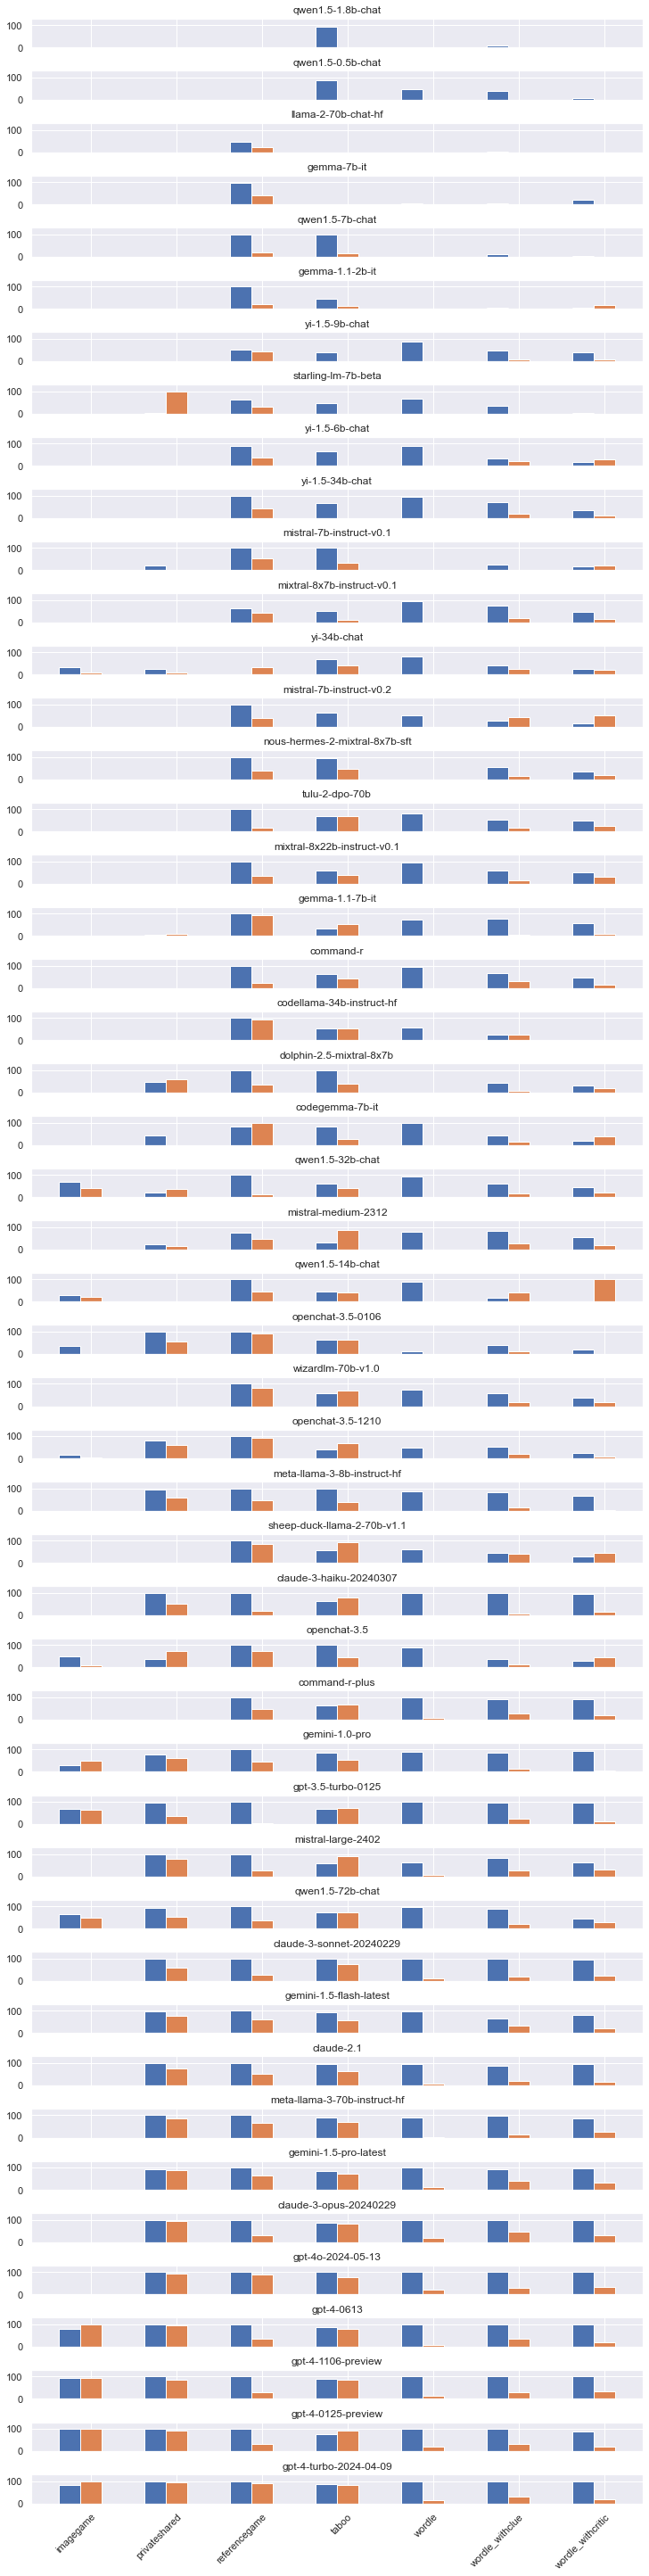

In [13]:
fig, axes = plt.subplots(layout='constrained', nrows=len(merged), ncols=1, sharex=True)

ax_counter = 0

for this_model in merged.sort_values(by='-, clemscore').model.values:        
    groups = [
        'imagegame',
        'privateshared',
        'referencegame',
        'taboo',
        'wordle',
        'wordle_withclue',
        'wordle_withcritic'    
    ]

    attributes = ['% Played', 'Quality Score']

    row = merged[merged.model == this_model]

    out_dict = {}
    for attribute in attributes:
        this_vals = []
        for group in groups:
            colname = group + ', ' + attribute
            this_vals.append(row[colname].values[0])
        out_dict[attribute] = this_vals
        
    ylabel = 'value (0-100)'
    title = this_model

    barplot_maker(fig, axes[ax_counter], groups, out_dict,
                  ylabel=ylabel, title=title, ylim=(0,130),
                  show_labels=False, show_ylabel=False, show_legend=False)
    ax_counter += 1


fig.set_size_inches(10, 40)

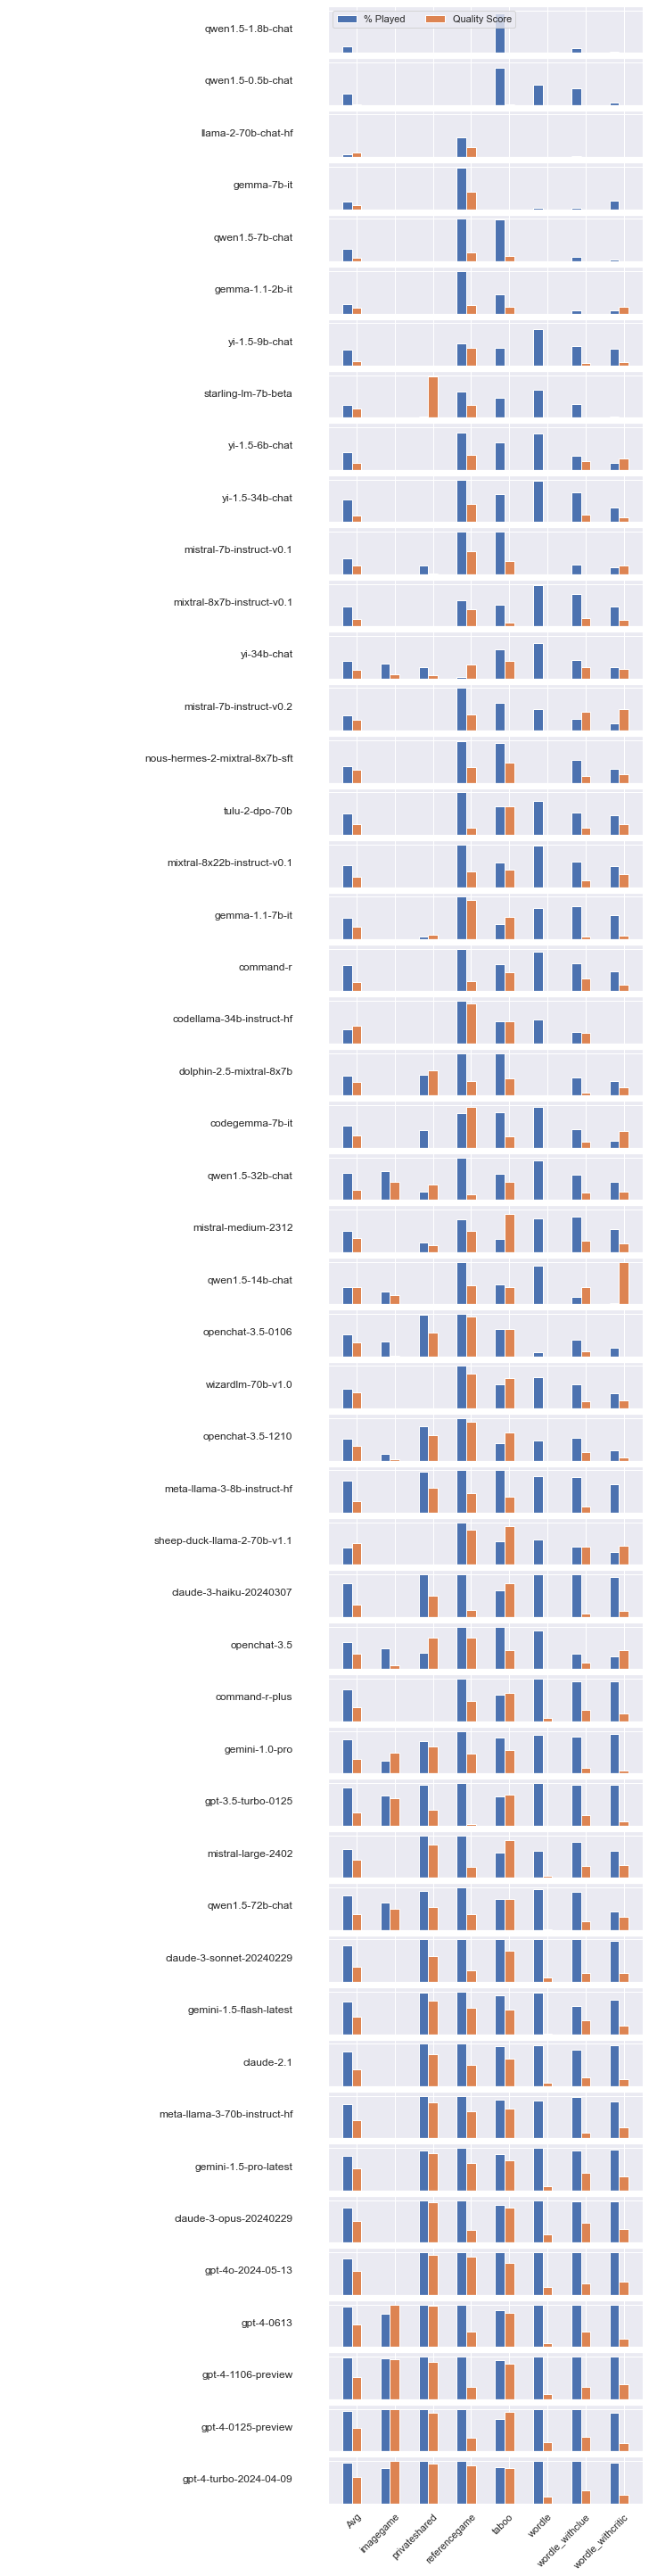

In [14]:
fig, axes = plt.subplots(layout='constrained', nrows=len(merged), ncols=2,
                         sharex=True, sharey=True)

ax_row_counter = 0


mcop = merged.rename(columns={'all, Average % Played': 'Avg, % Played',
                              'all, Average Quality Score': 'Avg, Quality Score'})
#mcop = merged

for this_model in mcop.sort_values(by='-, clemscore').model.values:        
    groups = [
        'Avg',
        'imagegame',
        'privateshared',
        'referencegame',
        'taboo',
        'wordle',
        'wordle_withclue',
        'wordle_withcritic'    
    ]

    attributes = ['% Played', 'Quality Score']

    row = mcop[mcop.model == this_model]

    out_dict = {}
    for attribute in attributes:
        this_vals = []
        for group in groups:
            colname = group + ', ' + attribute
            this_vals.append(row[colname].values[0])
        out_dict[attribute] = this_vals
        
    ylabel = 'value (0-100)'
    title = this_model
 
    # fake column just for model names
    this_axis = axes[ax_row_counter, 0]
    this_axis.text(7, 50, this_model, horizontalalignment='right')
    #this_axis.xlim(0, 1)
    this_axis.axis('off')

    this_axis = axes[ax_row_counter, 1]
    if ax_row_counter == 0:
        show_legend = True
    else:
        show_legend = False
    barplot_maker(fig, this_axis, groups, out_dict,
                  ylabel=ylabel, title=title, ylim=(0,110),
                  show_labels=False, show_ylabel=False, show_title=False, show_legend=show_legend)
    ax_row_counter += 1


fig.set_size_inches(10, 40)

In [15]:
merged.model.values

array(['yi-34b-chat', 'yi-1.5-6b-chat', 'yi-1.5-9b-chat',
       'yi-1.5-34b-chat', 'tulu-2-dpo-70b', 'claude-2.1',
       'claude-3-haiku-20240307', 'claude-3-sonnet-20240229',
       'claude-3-opus-20240229', 'dolphin-2.5-mixtral-8x7b', 'command-r',
       'command-r-plus', 'gemma-1.1-7b-it', 'gemma-7b-it',
       'gemini-1.5-flash-latest', 'gemini-1.5-pro-latest',
       'gemini-1.0-pro', 'codegemma-7b-it', 'gemma-1.1-2b-it',
       'meta-llama-3-8b-instruct-hf', 'meta-llama-3-70b-instruct-hf',
       'llama-2-70b-chat-hf', 'codellama-34b-instruct-hf',
       'mistral-7b-instruct-v0.1', 'mixtral-8x7b-instruct-v0.1',
       'mixtral-8x22b-instruct-v0.1', 'mistral-medium-2312',
       'mistral-large-2402', 'mistral-7b-instruct-v0.2',
       'starling-lm-7b-beta', 'nous-hermes-2-mixtral-8x7b-sft',
       'gpt-3.5-turbo-0125', 'gpt-4-0613', 'gpt-4-1106-preview',
       'gpt-4-0125-preview', 'gpt-4-turbo-2024-04-09',
       'gpt-4o-2024-05-13', 'openchat-3.5', 'openchat-3.5-1210',
      

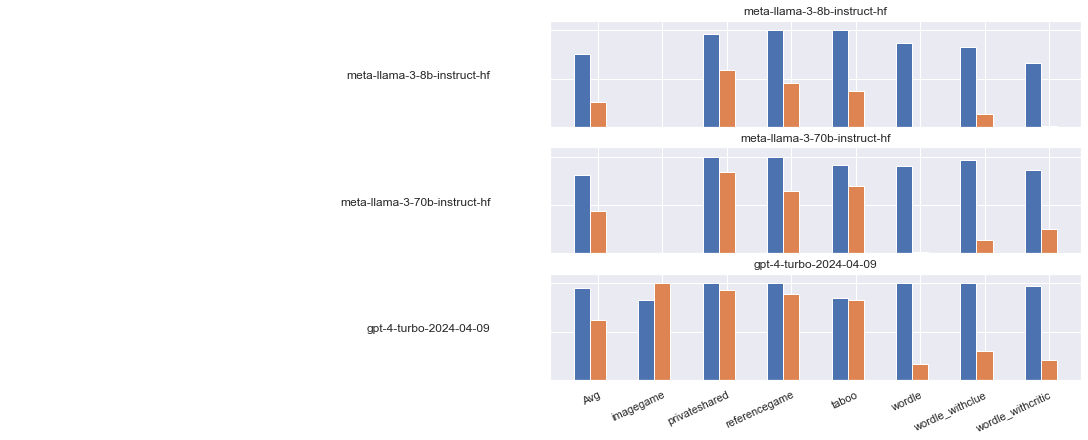

In [16]:

ax_row_counter = 0

mcop = merged.rename(columns={'all, Average % Played': 'Avg, % Played',
                              'all, Average Quality Score': 'Avg, Quality Score'})

these_models = [
    'meta-llama-3-8b-instruct-hf',
#    'openchat-3.5',
    'meta-llama-3-70b-instruct-hf',
    'gpt-4-turbo-2024-04-09'
]

fig, axes = plt.subplots(layout='constrained', nrows=len(these_models), ncols=2,
                         sharex=True, sharey=True)


for this_model in these_models:        
    groups = [
        'Avg',
        'imagegame',
        'privateshared',
        'referencegame',
        'taboo',
        'wordle',
        'wordle_withclue',
        'wordle_withcritic'    
    ]

    attributes = ['% Played', 'Quality Score']

    row = mcop[mcop.model == this_model]

    out_dict = {}
    for attribute in attributes:
        this_vals = []
        for group in groups:
            colname = group + ', ' + attribute
            this_vals.append(row[colname].values[0])
        out_dict[attribute] = this_vals
        
    ylabel = 'value (0-100)'
    title = this_model
 
    # fake column just for model names
    this_axis = axes[ax_row_counter, 0]
    this_axis.text(7, 50, this_model, horizontalalignment='right')
    #this_axis.xlim(0, 1)
    this_axis.axis('off')

    this_axis = axes[ax_row_counter, 1]
    if ax_row_counter == 0:
        show_legend = True
    else:
        show_legend = False
    barplot_maker(fig, this_axis, groups, out_dict,
                  ylabel=ylabel, title=title, ylim=(0,110),
                  rotation=25,
                  show_labels=False, show_ylabel=False, show_title=True, show_legend=False)
    ax_row_counter += 1


fig.set_size_inches(15, 6)
plt.savefig('Out/example_profiles.png', bbox_inches='tight')

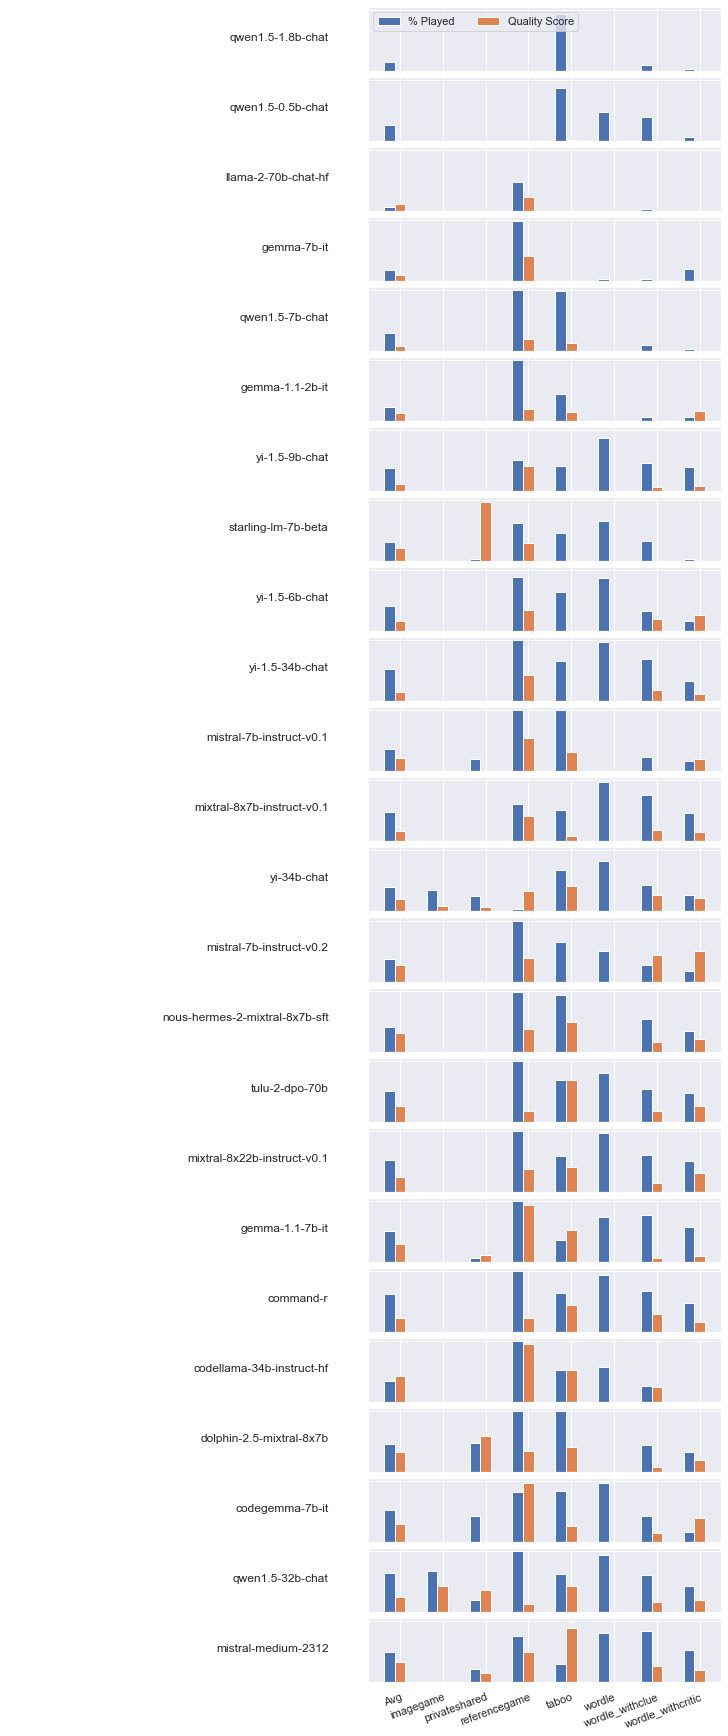

In [17]:
mcop = merged.rename(columns={'all, Average % Played': 'Avg, % Played',
                              'all, Average Quality Score': 'Avg, Quality Score'})

mcop = mcop.sort_values(by='-, clemscore')[:24]

fig, axes = plt.subplots(layout='constrained', nrows=len(mcop), ncols=2,
                         sharex=True, sharey=True)

ax_row_counter = 0


for this_model in mcop.model.values:        
    groups = [
        'Avg',
        'imagegame',
        'privateshared',
        'referencegame',
        'taboo',
        'wordle',
        'wordle_withclue',
        'wordle_withcritic'    
    ]

    attributes = ['% Played', 'Quality Score']

    row = mcop[mcop.model == this_model]

    out_dict = {}
    for attribute in attributes:
        this_vals = []
        for group in groups:
            colname = group + ', ' + attribute
            this_vals.append(row[colname].values[0])
        out_dict[attribute] = this_vals
        
    ylabel = 'value (0-100)'
    title = this_model
 
    # fake column just for model names
    this_axis = axes[ax_row_counter, 0]
    this_axis.text(7, 50, this_model, horizontalalignment='right')
    #this_axis.xlim(0, 1)
    this_axis.axis('off')

    this_axis = axes[ax_row_counter, 1]
    if ax_row_counter == 0:
        show_legend = True
    else:
        show_legend = False
    barplot_maker(fig, this_axis, groups, out_dict,
                  ylabel=ylabel, title=title, ylim=(0,105),
                  rotation=20,
                  show_labels=False, show_ylabel=False, show_title=False, show_legend=show_legend)
    ax_row_counter += 1


fig.set_size_inches(10, len(mcop))
plt.savefig('Out/all_profiles_1.png', bbox_inches='tight')

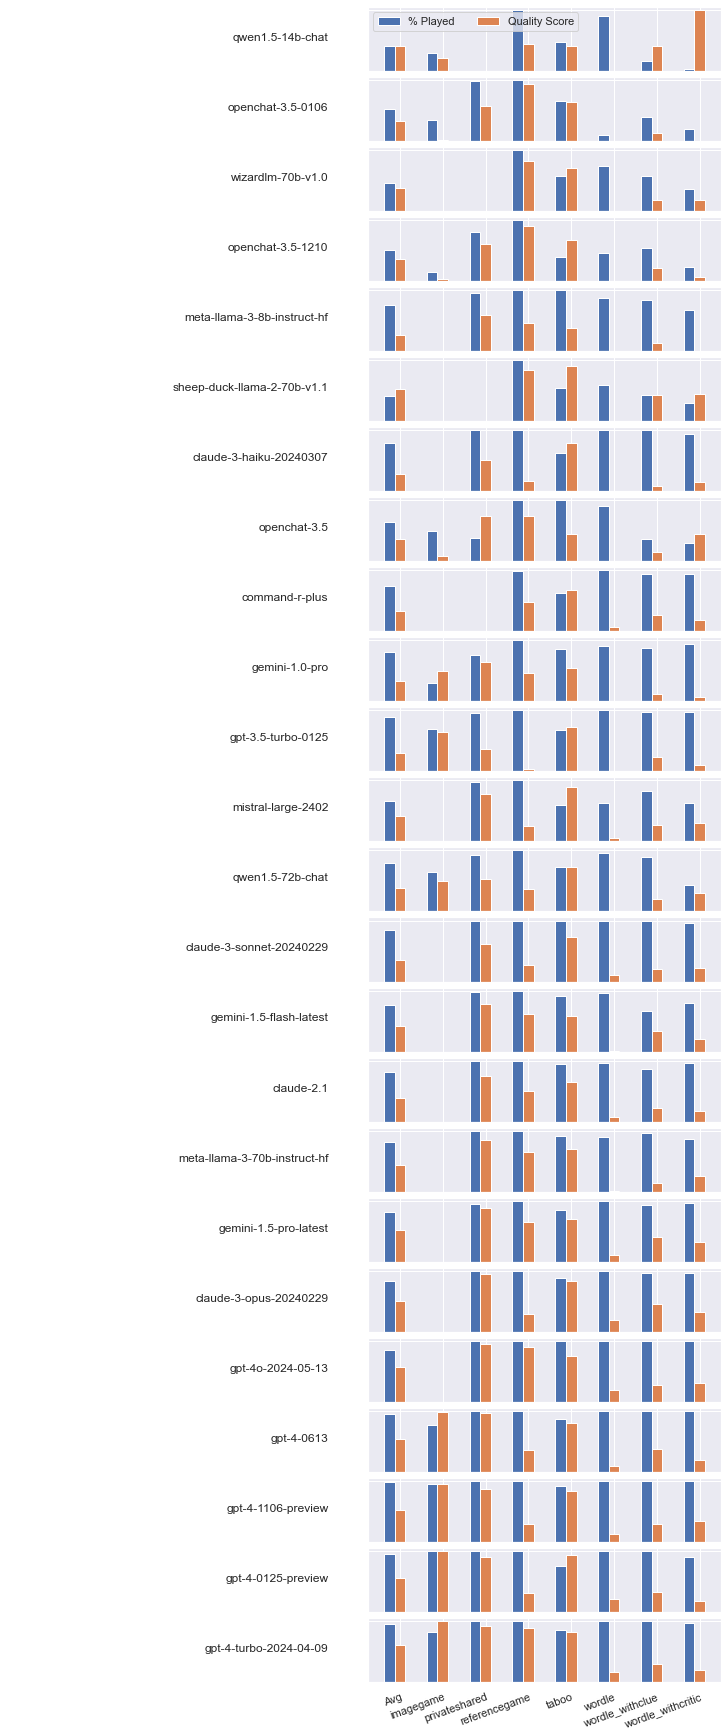

In [18]:
mcop = merged.rename(columns={'all, Average % Played': 'Avg, % Played',
                              'all, Average Quality Score': 'Avg, Quality Score'})

mcop = mcop.sort_values(by='-, clemscore')[24:]

fig, axes = plt.subplots(layout='constrained', nrows=len(mcop), ncols=2,
                         sharex=True, sharey=True)

ax_row_counter = 0


for this_model in mcop.model.values:        
    groups = [
        'Avg',
        'imagegame',
        'privateshared',
        'referencegame',
        'taboo',
        'wordle',
        'wordle_withclue',
        'wordle_withcritic'    
    ]

    attributes = ['% Played', 'Quality Score']

    row = mcop[mcop.model == this_model]

    out_dict = {}
    for attribute in attributes:
        this_vals = []
        for group in groups:
            colname = group + ', ' + attribute
            this_vals.append(row[colname].values[0])
        out_dict[attribute] = this_vals
        
    ylabel = 'value (0-100)'
    title = this_model
 
    # fake column just for model names
    this_axis = axes[ax_row_counter, 0]
    this_axis.text(7, 50, this_model, horizontalalignment='right')
    #this_axis.xlim(0, 1)
    this_axis.axis('off')

    this_axis = axes[ax_row_counter, 1]
    if ax_row_counter == 0:
        show_legend = True
    else:
        show_legend = False
    barplot_maker(fig, this_axis, groups, out_dict,
                  ylabel=ylabel, title=title, ylim=(0,105),
                  rotation=20,
                  show_labels=False, show_ylabel=False, show_title=False, show_legend=show_legend)
    ax_row_counter += 1


fig.set_size_inches(10, len(mcop))
plt.savefig('Out/all_profiles_2.png', bbox_inches='tight')

In [19]:
(merged.
 dropna(subset='Parameter Size (in billions)').
 sort_values(by=['Parameter Size (in billions)', '-, clemscore'], ascending=[True,True]).
 reset_index(drop=True) #.
 # plot.line(use_index=True, y='imagegame, % Played', figsize=(10,2))
)

,Model Provider,Model Name,Training Data Size (in trillions),Cut-off Date,Parameter Size (in billions),Release Date,Context Length (in thousands),Commercial,Multilingual,Multimodal,...,"wordle, % Played","wordle, Quality Score","wordle, Quality Score (std)","wordle_withclue, % Played","wordle_withclue, Quality Score","wordle_withclue, Quality Score (std)","wordle_withcritic, % Played","wordle_withcritic, Quality Score","wordle_withcritic, Quality Score (std)",model
0,Qwen,qwen1.5-0.5b-chat,2.2,NaT,0.5,2024-02-01,32,0,1,0,...,46.67,0.00,0.00,40.00,0.00,0.00,6.67,0.00,0.00,qwen1.5-0.5b-chat
1,Qwen,qwen1.5-1.8b-chat,2.2,NaT,1.8,2024-02-01,32,0,1,0,...,0.00,NaN,NaN,10.00,0.00,0.00,3.33,0.00,NaN,qwen1.5-1.8b-chat
2,Google,gemma-1.1-2b-it,3.0,NaT,2.0,2024-04-01,8,0,0,0,...,0.00,NaN,NaN,6.67,0.00,0.00,6.67,16.66,23.57,gemma-1.1-2b-it
3,01-ai,yi-1.5-6b-chat,3.6,NaT,6.0,2024-05-01,32,0,1,0,...,86.67,0.00,0.00,33.33,20.00,42.16,16.67,26.67,43.46,yi-1.5-6b-chat
4,Google,gemma-7b-it,6.0,NaT,7.0,2024-02-01,8,0,0,0,...,3.33,0.00,NaN,3.33,0.00,NaN,20.00,0.00,0.00,gemma-7b-it
5,Qwen,qwen1.5-7b-chat,2.4,NaT,7.0,2024-02-01,32,0,1,0,...,0.00,NaN,NaN,10.00,0.00,0.00,3.33,0.00,NaN,qwen1.5-7b-chat
6,Nexusflow,starling-lm-7b-beta,NaN,NaT,7.0,2024-03-01,8,0,0,0,...,66.67,0.00,0.00,33.33,0.00,0.00,3.33,0.00,NaN,starling-lm-7b-beta
7,Mistralai,mistral-7b-instruct-v0.1,NaN,NaT,7.0,2023-09-01,8,0,0,0,...,0.00,NaN,NaN,23.33,0.00,0.00,16.67,20.00,44.72,mistral-7b-instruct-v0.1
8,Mistralai,mistral-7b-instruct-v0.2,NaN,NaT,7.0,2023-12-01,32,0,0,0,...,50.00,0.00,0.00,26.67,43.75,49.55,16.67,50.00,50.00,mistral-7b-instruct-v0.2
9,Google,gemma-1.1-7b-it,NaN,NaT,7.0,2024-04-01,8,0,0,0,...,73.33,0.00,0.00,76.67,6.52,22.88,56.67,8.82,26.43,gemma-1.1-7b-it


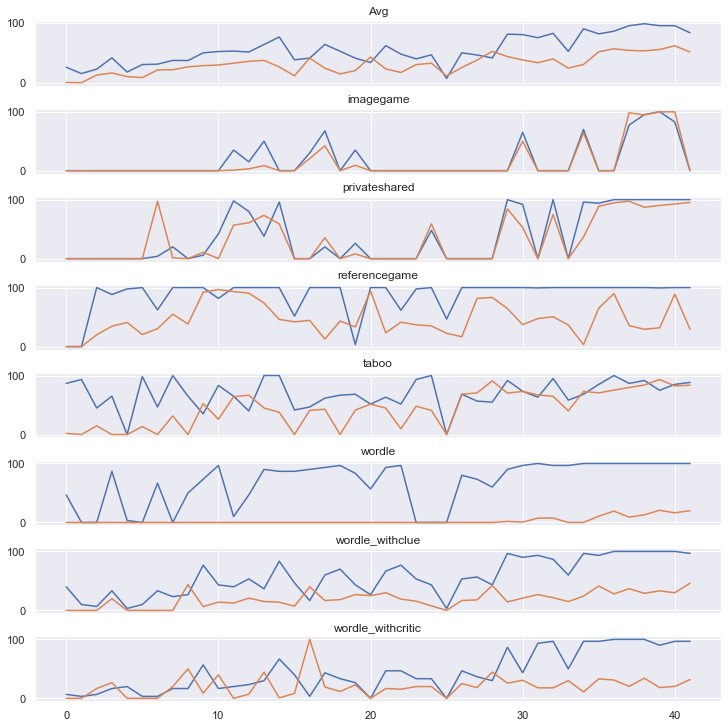

In [20]:
mcop = merged.rename(columns={'all, Average % Played': 'Avg, % Played',
                              'all, Average Quality Score': 'Avg, Quality Score'})

groups = [
        'Avg',
        'imagegame',
        'privateshared',
        'referencegame',
        'taboo',
        'wordle',
        'wordle_withclue',
        'wordle_withcritic'    
]

attributes = ['% Played', 'Quality Score']

#plot_cols = [g + ', ' + a for g in groups for a in attributes ]

fig, axes = plt.subplots(layout='constrained', nrows=len(groups), ncols=1,
                         sharex=True) #, sharey=True)

for n, this_group in enumerate(groups):

    plot_cols = [this_group + ', ' + a for a in attributes]


    ax = \
    (mcop.
     dropna(subset='Parameter Size (in billions)').
     fillna(value={v: 0 for v in plot_cols}).
     sort_values(by=['Parameter Size (in billions)', '-, clemscore'], ascending=[True,True]).
     reset_index(drop=True).
     plot.line(use_index=True, y=plot_cols, legend=False, title=this_group, ax=axes[n])
    )

fig.set_size_inches(10, 10)
plt.savefig('Out/dynamics.png', bbox_inches='tight')